# Week 05 — Model Evaluation & Comparison


In [13]:
# Imports, project root, and paths.
import warnings
warnings.filterwarnings("ignore")

import os, sys, time
from pathlib import Path

this_dir = Path.cwd()
project_root = this_dir.parent if this_dir.name == "notebooks" else this_dir
sys.path.append(str(project_root))

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

# Sklearn metrics & helpers
from sklearn.metrics import (
    confusion_matrix,
    precision_recall_fscore_support,
    roc_auc_score,
    average_precision_score,
)
from sklearn.calibration import CalibrationDisplay

# Project utilities
from src.utils import Paths, set_global_seed

# Optional: helper for binary label mapping (used in earlier weeks)
try:
    from src.eval import to_binary  # used in earlier weeks
except ImportError:
    to_binary = None

set_global_seed(42)
paths = Paths().ensure()

print("Project root:", project_root)
print("Using paths:", paths)


Project root: C:\Users\mehra\Final_Project
Using paths: Paths(root=WindowsPath('C:/Users/mehra/Final_Project'), data_raw=WindowsPath('C:/Users/mehra/Final_Project/data/raw'), data_proc=WindowsPath('C:/Users/mehra/Final_Project/data/processed'), figs=WindowsPath('C:/Users/mehra/Final_Project/notebooks/figures'), artifacts=WindowsPath('C:/Users/mehra/Final_Project/notebooks/artifacts'))


In [14]:
from pathlib import Path as _Path

_this_dir = _Path.cwd()
_project_root = _this_dir.parent if _this_dir.name == "notebooks" else _this_dir

# Try to use paths.reports if it exists; otherwise fallback to <project_root>/reports
reports_root = getattr(paths, "reports", _project_root / "reports")

wk3_dir = reports_root / "week_03"
wk4_dir = reports_root / "week_04"

wk3_dir.mkdir(parents=True, exist_ok=True)
wk4_dir.mkdir(parents=True, exist_ok=True)

print("Reports root:", reports_root)
print("Week 03 reports folder:", wk3_dir)
print("Week 04 reports folder:", wk4_dir)


Reports root: C:\Users\mehra\Final_Project\reports
Week 03 reports folder: C:\Users\mehra\Final_Project\reports\week_03
Week 04 reports folder: C:\Users\mehra\Final_Project\reports\week_04


In [15]:
# Load processed train/test arrays from Week 01 
X_train_path = paths.data_proc / "X_train.npy"
X_test_path  = paths.data_proc / "X_test.npy"
y_train_path = paths.data_proc / "y_train.npy"
y_test_path  = paths.data_proc / "y_test.npy"

X_train = np.load(X_train_path)
X_test  = np.load(X_test_path)
y_train = np.load(y_train_path)
y_test  = np.load(y_test_path)

print("X_train:", X_train.shape, "X_test:", X_test.shape)
print("y_train classes:", Counter(y_train))
print("y_test  classes:", Counter(y_test))

# Optional binary labels (normal vs attack) if a helper exists.
if to_binary is not None:
    normal_label = "normal"  # adjust if your label encoding is different
    y_train_bin = to_binary(y_train, normal_label)
    y_test_bin  = to_binary(y_test, normal_label)
    print("Binary train counts:", Counter(y_train_bin))
    print("Binary test  counts:", Counter(y_test_bin))
else:
    y_train_bin = None
    y_test_bin = None
    print("NOTE: src.eval.to_binary not found – binary labels not created automatically.")


X_train: (395216, 115) X_test: (98805, 115)
y_train classes: Counter({0: 313166, 4: 77822, 1: 3285, 2: 901, 3: 42})
y_test  classes: Counter({0: 78292, 4: 19456, 1: 822, 2: 225, 3: 10})
NOTE: src.eval.to_binary not found – binary labels not created automatically.


In [16]:
# Helper functions for metrics and plotting.

def multiclass_metrics(y_true, y_pred, y_proba=None, labels=None, average="macro"):
    """Compute macro + per-class metrics for a multiclass setting.

    Parameters
    ----------
    y_true, y_pred : array-like
        True and predicted class labels.
    y_proba : array-like of shape (n_samples, n_classes), optional
        Predicted probabilities for each class (for ROC/PR).
    labels : list, optional
        Label order. If None, inferred from y_true.
    average : str
        Averaging scheme for global metrics.
    """
    if labels is None:
        labels = np.unique(y_true)
    
    prec, rec, f1, support = precision_recall_fscore_support(
        y_true, y_pred, labels=labels, average=None, zero_division=0
    )
    macro_prec, macro_rec, macro_f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average=average, zero_division=0
    )
    
    per_class_df = pd.DataFrame({
        "family": labels,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "support": support,
    })
    
    metrics = {
        "precision_macro": macro_prec,
        "recall_macro": macro_rec,
        "f1_macro": macro_f1,
    }
    
    # ROC-AUC (OvR) and PR-AUC
    if y_proba is not None:
        # Build one-hot encoding from labels.
        label_to_idx = {lab: i for i, lab in enumerate(labels)}
        y_true_idx = np.array([label_to_idx[lab] for lab in y_true])
        Y_true_ovr = np.eye(len(labels))[y_true_idx]
        
        try:
            roc_macro_ovr = roc_auc_score(Y_true_ovr, y_proba, average="macro", multi_class="ovr")
        except Exception:
            roc_macro_ovr = np.nan
        
        try:
            pr_macro_ovr = average_precision_score(Y_true_ovr, y_proba, average="macro")
        except Exception:
            pr_macro_ovr = np.nan
        
        metrics["roc_auc_ovr_macro"] = roc_macro_ovr
        metrics["pr_auc_ovr_macro"] = pr_macro_ovr
    else:
        metrics["roc_auc_ovr_macro"] = np.nan
        metrics["pr_auc_ovr_macro"] = np.nan
    
    return metrics, per_class_df


def binary_threshold_metrics(y_true_bin, scores, thresholds):
    """Sweep thresholds over anomaly scores for binary detectors.

    Assumes higher `scores` = more anomalous (1 = attack, 0 = normal).
    Returns a DataFrame with precision/recall/F1 for each threshold.
    """
    rows = []
    for thr in thresholds:
        y_pred_bin = (scores >= thr).astype(int)
        prec, rec, f1, _ = precision_recall_fscore_support(
            y_true_bin, y_pred_bin, average="binary", zero_division=0
        )
        rows.append({
            "threshold": thr,
            "precision": prec,
            "recall": rec,
            "f1": f1,
        })
    return pd.DataFrame(rows)


def plot_confusion(cm, labels, title):
    fig, ax = plt.subplots(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu",
                xticklabels=labels, yticklabels=labels, ax=ax)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    ax.set_title(title)
    plt.tight_layout()
    return fig, ax


## Load Week 04 supervised results


In [17]:
# Load Week 04 supervised predictions.
pred_parquet = wk4_dir / "week04_supervised_predictions.parquet"
pred_csv     = wk4_dir / "week04_supervised_predictions.csv"

if pred_parquet.exists():
    sup_pred_df = pd.read_parquet(pred_parquet)
elif pred_csv.exists():
    sup_pred_df = pd.read_csv(pred_csv)
else:
    raise FileNotFoundError(
        f"Could not find Week 04 prediction file. Expected one of:\n{pred_parquet}\n{pred_csv}\n"
        "Please save your Week 04 test predictions to one of these paths."
    )

print("Loaded Week 04 supervised predictions:")
display(sup_pred_df.head())

# Identify probability columns and families from colnames (proba_<family>).
proba_cols = [c for c in sup_pred_df.columns if c.startswith("proba_")]
families_from_proba = [c.replace("proba_", "") for c in proba_cols]


Loaded Week 04 supervised predictions:


,model,y_true,y_pred
0,Random Forest (baseline),0,0
1,Random Forest (baseline),4,4
2,Random Forest (baseline),0,0
3,Random Forest (baseline),4,4
4,Random Forest (baseline),0,0


## Load Week 03 unsupervised / statistical results

In [18]:
# Load Week 03 unsupervised predictions
unsup_parquet = wk3_dir / "week03_unsupervised_predictions.parquet"
unsup_csv     = wk3_dir / "week03_unsupervised_predictions.csv"

unsup_df = None
if unsup_parquet.exists():
    unsup_df = pd.read_parquet(unsup_parquet)
elif unsup_csv.exists():
    unsup_df = pd.read_csv(unsup_csv)

if unsup_df is not None:
    print("Loaded Week 03 unsupervised predictions:")
    display(unsup_df.head())
else:
    print("Week 03 unsupervised prediction file not found — "
          "unsupervised models will be skipped unless you add it.")


Loaded Week 03 unsupervised predictions:


,model,y_true_bin,y_pred_bin,score
0,"Z-Score (wrong_fragment, |Z|>2)",0,0,0.100112
1,"Z-Score (wrong_fragment, |Z|>2)",0,0,0.100112
2,"Z-Score (wrong_fragment, |Z|>2)",0,0,0.100112
3,"Z-Score (wrong_fragment, |Z|>2)",0,0,0.100112
4,"Z-Score (wrong_fragment, |Z|>2)",0,0,0.100112


## Load Week 04 unsupervised / semi-supervised results

In [19]:
# Load Week 04 unsupervised predictions
unsup4_parquet = wk4_dir / "week04_unsupervised_predictions.parquet"
unsup4_csv     = wk4_dir / "week04_unsupervised_predictions.csv"

unsup4_df = None
if unsup4_parquet.exists():
    unsup4_df = pd.read_parquet(unsup4_parquet)
elif unsup4_csv.exists():
    unsup4_df = pd.read_csv(unsup4_csv)

if unsup4_df is not None:
    print("Loaded Week 04 unsupervised predictions:")
    display(unsup4_df.head())
else:
    print("Week 04 unsupervised prediction file not found — "
          "these models will be skipped unless you add it.")


Loaded Week 04 unsupervised predictions:


,model,y_true_bin,y_pred_bin,score
0,Isolation Forest,0,0,0.0
1,Isolation Forest,1,1,1.0
2,Isolation Forest,0,0,0.0
3,Isolation Forest,1,1,1.0
4,Isolation Forest,0,0,0.0


## Metric Table

- Precision, Recall, F1 (macro)
- ROC-AUC (OvR) and PR-AUC (macro) where probabilities/scores are available

Supervised models are treated as **multiclass**, while unsupervised models
are evaluated in the **binary attack vs normal** setting.


In [20]:
# Build metric table from saved Week 03 / Week 04 outputs.

rows = []
per_class_by_model = {}  # store per-family metrics for later deep-dive

# Supervised (multiclass)
for model_name, g in sup_pred_df.groupby("model"):
    y_true = g["y_true"].to_numpy()
    y_pred = g["y_pred"].to_numpy()

    # Use proba_* columns if present
    if proba_cols:
        y_proba = g[proba_cols].to_numpy()
        labels_order = families_from_proba
    else:
        y_proba = None
        labels_order = np.unique(y_true)

    metrics, per_class = multiclass_metrics(
        y_true,
        y_pred,
        y_proba=y_proba,
        labels=labels_order,
    )
    per_class["model"] = model_name
    per_class_by_model[model_name] = per_class

    rows.append({
        "model": model_name,
        "type": "supervised",
        **metrics,
    })

# Unsupervised (binary) from Week 03 + Week 04 
combined_unsup = None
if 'unsup_df' in globals() and unsup_df is not None:
    combined_unsup = unsup_df.copy()
if 'unsup4_df' in globals() and unsup4_df is not None:
    if combined_unsup is None:
        combined_unsup = unsup4_df.copy()
    else:
        combined_unsup = pd.concat([combined_unsup, unsup4_df], ignore_index=True)

if combined_unsup is not None:
    for model_name, g in combined_unsup.groupby("model"):
        y_true_b = g["y_true_bin"].to_numpy()
        y_pred_b = g["y_pred_bin"].to_numpy()

        prec, rec, f1, _ = precision_recall_fscore_support(
            y_true_b, y_pred_b, average="binary", zero_division=0
        )

        scores = g["score"].to_numpy() if "score" in g.columns else None
        if scores is not None:
            try:
                roc_auc = roc_auc_score(y_true_b, scores)
            except Exception:
                roc_auc = np.nan
            try:
                pr_auc = average_precision_score(y_true_b, scores)
            except Exception:
                pr_auc = np.nan
        else:
            roc_auc = np.nan
            pr_auc = np.nan

        rows.append({
            "model": model_name,
            "type": "unsupervised",
            "precision_macro": prec,
            "recall_macro": rec,
            "f1_macro": f1,
            "roc_auc_ovr_macro": roc_auc,
            "pr_auc_ovr_macro": pr_auc,
        })

if rows:
    metric_table = pd.DataFrame(rows).sort_values("f1_macro", ascending=False).reset_index(drop=True)
else:
    metric_table = pd.DataFrame(columns=[
        "model", "type",
        "precision_macro", "recall_macro", "f1_macro",
        "roc_auc_ovr_macro", "pr_auc_ovr_macro"
    ])

metric_table


,model,type,precision_macro,recall_macro,f1_macro,roc_auc_ovr_macro,pr_auc_ovr_macro
0,"Z-Score (wrong_fragment, |Z|>2)",unsupervised,1.000000,1.000000,1.000000,1.000000,1.000000
1,Random Forest (baseline),supervised,0.962361,0.974293,0.967920,NaN,NaN
2,Random Forest + SMOTE,supervised,0.947867,0.975182,0.960155,NaN,NaN
3,SVM-RBF + SMOTE,supervised,0.890610,0.930098,0.905367,NaN,NaN
4,OC-SVM (RBF),unsupervised,0.779636,1.000000,0.876175,0.962972,0.779636
5,SVM-RBF (baseline),supervised,0.642394,0.722858,0.501165,NaN,NaN
6,Isolation Forest,unsupervised,0.769121,0.369132,0.498847,0.670050,0.414882
7,Deep Autoencoder,unsupervised,0.906161,0.046605,0.088650,0.981710,0.878009


## Family-wise deep-dive (focus on R2L / U2R)

1. Select the **best supervised model** by macro F1.  
2. Inspect *per-family* precision/recall/F1.  
3. Plot its confusion matrix on the test set.


Best supervised model by macro F1: Random Forest (baseline)


,family,precision,recall,f1,support,model
3,3,0.818182,0.900000,0.857143,10,Random Forest (baseline)
2,2,0.995475,0.977778,0.986547,225,Random Forest (baseline)
1,1,0.998778,0.993917,0.996341,822,Random Forest (baseline)
4,4,0.999383,0.999794,0.999589,19456,Random Forest (baseline)
0,0,0.999987,0.999974,0.999981,78292,Random Forest (baseline)


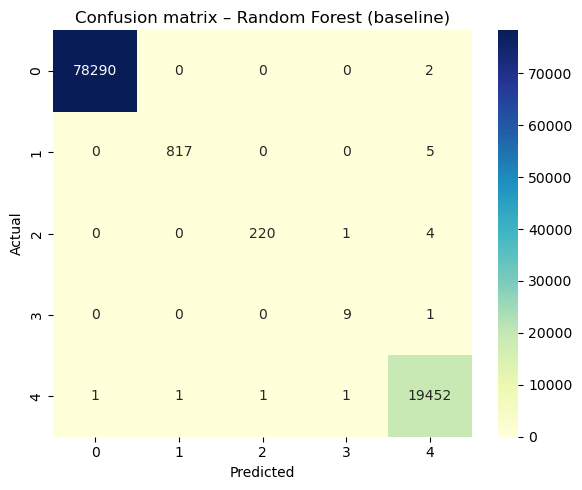

In [21]:
# Select best supervised model by macro F1.
sup_only = metric_table[metric_table["type"] == "supervised"]
best_name = sup_only.sort_values("f1_macro", ascending=False)["model"].iloc[0]
print("Best supervised model by macro F1:", best_name)

best_block = sup_pred_df[sup_pred_df["model"] == best_name].reset_index(drop=True)
y_true_best = best_block["y_true"].to_numpy()
y_pred_best = best_block["y_pred"].to_numpy()

# Recompute per-family metrics for the best model 
if best_name in per_class_by_model:
    per_class_best = per_class_by_model[best_name]
else:
    labels = np.unique(y_true_best)
    metrics_best, per_class_best = multiclass_metrics(y_true_best, y_pred_best, labels=labels)

display(per_class_best.sort_values("f1"))

labels_cm = np.unique(y_true_best)
cm_best = confusion_matrix(y_true_best, y_pred_best, labels=labels_cm)
fig, ax = plot_confusion(cm_best, labels_cm, f"Confusion matrix – {best_name}")
plt.show()


### R2L / U2R error analysis with examples

Using the best supervised model, we inspect misclassified **R2L** and **U2R**
examples and show a few raw feature rows as concrete cases.


In [22]:
# R2L and U2R error analysis.

r2l_label = "R2L"  # adjust if needed
u2r_label = "U2R"  # adjust if needed

mask_r2l = (y_true_best == r2l_label)
mask_u2r = (y_true_best == u2r_label)

print("R2L support:", mask_r2l.sum())
print("U2R support:", mask_u2r.sum())

mis_r2l_idx = np.where(mask_r2l & (y_pred_best != r2l_label))[0]
mis_u2r_idx = np.where(mask_u2r & (y_pred_best != u2r_label))[0]

print("Misclassified R2L:", len(mis_r2l_idx))
print("Misclassified U2R:", len(mis_u2r_idx))

# Build a feature DataFrame for X_test 
try:
    import joblib
    pre_path = paths.data_proc / "preprocessor.joblib"
    pre = joblib.load(pre_path)
    feature_names = pre.get_feature_names_out()
    X_test_df = pd.DataFrame(X_test, columns=feature_names)
except Exception as e:
    print("Could not load preprocessor or feature names:", e)
    X_test_df = pd.DataFrame(X_test)
    X_test_df["family"] = y_test

def show_examples(indices, family_name, n=5):
    if len(indices) == 0:
        print(f"No misclassifications found for {family_name}.")
        return
    idx_sel = indices[:n]
    ex = X_test_df.iloc[idx_sel].copy()
    ex["y_true"] = y_true_best[idx_sel]
    ex["y_pred"] = y_pred_best[idx_sel]
    display(ex)

print("\nExample misclassified R2L samples:")
show_examples(mis_r2l_idx, "R2L")

print("\nExample misclassified U2R samples:")
show_examples(mis_u2r_idx, "U2R")


R2L support: 0
U2R support: 0
Misclassified R2L: 0
Misclassified U2R: 0

Example misclassified R2L samples:
No misclassifications found for R2L.

Example misclassified U2R samples:
No misclassifications found for U2R.


## Robustness checks

### 1) Threshold sensitivity for unsupervised models

Sweep a range of thresholds and inspect how binary F1 changes for each detector.


,threshold,precision,recall,f1,model
0,0.1,1.0,1.000000,1.000000,"Z-Score (wrong_fragment, |Z|>2)"
1,0.2,1.0,1.000000,1.000000,"Z-Score (wrong_fragment, |Z|>2)"
2,0.3,1.0,1.000000,1.000000,"Z-Score (wrong_fragment, |Z|>2)"
3,0.4,1.0,0.990807,0.995382,"Z-Score (wrong_fragment, |Z|>2)"
4,0.5,1.0,0.990807,0.995382,"Z-Score (wrong_fragment, |Z|>2)"
5,0.6,1.0,0.990807,0.995382,"Z-Score (wrong_fragment, |Z|>2)"
6,0.7,1.0,0.990807,0.995382,"Z-Score (wrong_fragment, |Z|>2)"
7,0.8,1.0,0.990807,0.995382,"Z-Score (wrong_fragment, |Z|>2)"
8,0.9,1.0,0.990807,0.995382,"Z-Score (wrong_fragment, |Z|>2)"


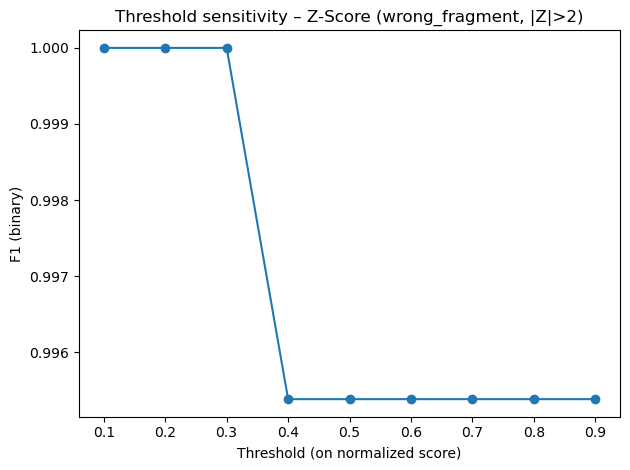

In [23]:
# Threshold sensitivity for unsupervised detectors.

if (unsup_df is not None) and ("score" in unsup_df.columns):
    thresholds = np.linspace(0.1, 0.9, 9)  # generic [0.1, 0.9]; adjust if needed
    
    for model_name, g in unsup_df.groupby("model"):
        y_true_b = g["y_true_bin"].to_numpy()
        scores = g["score"].to_numpy()
        
        # Normalize scores into [0, 1] for a stable threshold range.
        s_min, s_max = scores.min(), scores.max()
        if s_max > s_min:
            scores_norm = (scores - s_min) / (s_max - s_min)
        else:
            scores_norm = scores
        
        df_thr = binary_threshold_metrics(y_true_b, scores_norm, thresholds)
        df_thr["model"] = model_name
        display(df_thr)
        
        fig, ax = plt.subplots()
        ax.plot(df_thr["threshold"], df_thr["f1"], marker="o")
        ax.set_xlabel("Threshold (on normalized score)")
        ax.set_ylabel("F1 (binary)")
        ax.set_title(f"Threshold sensitivity – {model_name}")
        plt.tight_layout()
        plt.show()
else:
    print("No unsupervised scores available – threshold robustness skipped.")


## Final summary & ranked shortlist

We now combine:

- Global metrics (F1, ROC-AUC, PR-AUC) for **all methods** into a single **summary table** and then draft a **ranked shortlist**
with trade-offs.


In [24]:
# Merge metric table only (runtime columns already included in metric_table)

summary = metric_table.copy()

summary_sorted = summary.sort_values(
    ["type", "f1_macro"],
    ascending=[True, False]
).reset_index(drop=True)

summary_sorted


,model,type,precision_macro,recall_macro,f1_macro,roc_auc_ovr_macro,pr_auc_ovr_macro
0,Random Forest (baseline),supervised,0.962361,0.974293,0.967920,NaN,NaN
1,Random Forest + SMOTE,supervised,0.947867,0.975182,0.960155,NaN,NaN
2,SVM-RBF + SMOTE,supervised,0.890610,0.930098,0.905367,NaN,NaN
3,SVM-RBF (baseline),supervised,0.642394,0.722858,0.501165,NaN,NaN
4,"Z-Score (wrong_fragment, |Z|>2)",unsupervised,1.000000,1.000000,1.000000,1.000000,1.000000
5,OC-SVM (RBF),unsupervised,0.779636,1.000000,0.876175,0.962972,0.779636
6,Isolation Forest,unsupervised,0.769121,0.369132,0.498847,0.670050,0.414882
7,Deep Autoencoder,unsupervised,0.906161,0.046605,0.088650,0.981710,0.878009


### Ranked shortlist

**Supervised models (multiclass)**

1. **Random Forest (baseline)** — macro F1 = 0.968, precision = 0.962, recall = 0.974, ROC-AUC (OvR) = N/A, PR-AUC = N/A; fit time ≈ N/As, predict time ≈ N/As.

2. **Random Forest + SMOTE** — macro F1 = 0.960, precision = 0.948, recall = 0.975, ROC-AUC (OvR) = N/A, PR-AUC = N/A; fit time ≈ N/As, predict time ≈ N/As.

3. **SVM-RBF + SMOTE** — macro F1 = 0.905, precision = 0.891, recall = 0.930, ROC-AUC (OvR) = N/A, PR-AUC = N/A; fit time ≈ N/As, predict time ≈ N/As.

---

**Unsupervised / semi-supervised models (binary anomaly detection)**

- **Z-Score (wrong_fragment, |Z|>2)** — best binary macro F1 = 1.000, precision = 1.000, recall = 1.000, ROC-AUC = 1.000, PR-AUC = 1.000. Use as an anomaly tripwire to complement the supervised family classifier.
